# Отток пользователей у мобильного оператора #

In [3]:
import os
import pandas as pd
import numpy as np
import itertools
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier as tree
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as ss
# from sklearn.externals.six import StringIO  
# from IPython.display import Image  
# from sklearn.tree import export_graphviz
# import pydotplus
from dtreeviz.trees import dtreeviz

In [4]:
data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [5]:
data.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


In [6]:
data.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

## График зависимости категориальных показателей ##

*https://stackoverflow.com/questions/46498455/categorical-features-correlation/46498792#46498792*

Text(0.5, 1, 'Cramer V Correlation between Variables')

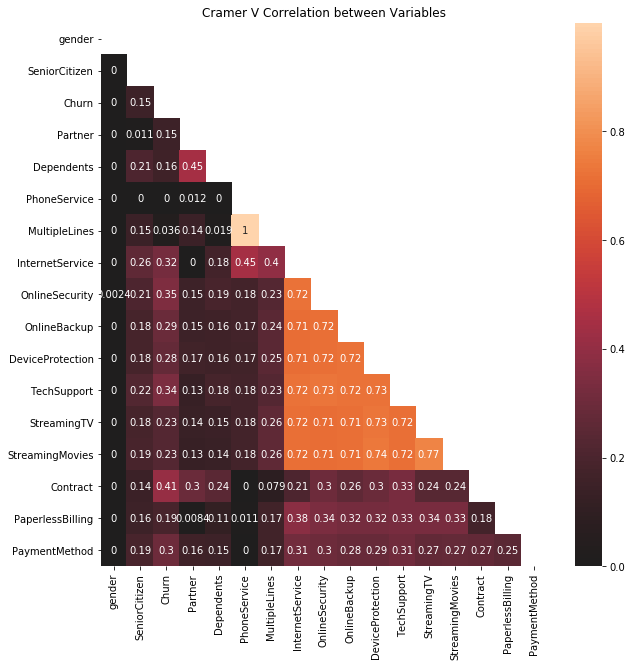

In [7]:
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorical-categorical association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))


cols = ['gender', 'SeniorCitizen', 'Churn','Partner', 'Dependents','PhoneService', 'MultipleLines', 'InternetService',
        'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
        'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling','PaymentMethod']
corrM = np.zeros((len(cols),len(cols)))
# there's probably a nice pandas way to do this
for col1, col2 in itertools.combinations(cols, 2):
    idx1, idx2 = cols.index(col1), cols.index(col2)
    corrM[idx1, idx2] = cramers_corrected_stat(pd.crosstab(data[col1], data[col2]))
    corrM[idx2, idx1] = corrM[idx1, idx2]

corr = pd.DataFrame(corrM, index=cols, columns=cols)
mask = np.triu(np.ones_like(corr, dtype=bool))
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(corr,  mask=mask, annot=True, center=0, ax=ax); ax.set_title("Cramer V Correlation between Variables")

## График зависимости количественных показателей ##

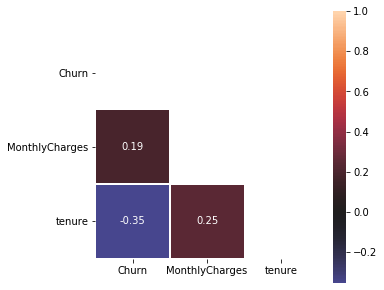

In [8]:
data['Churn'] = data['Churn'].apply(lambda x:  1 if x=='Yes' else 0)

corr = data[['Churn', 'MonthlyCharges', 'TotalCharges', 'tenure']].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
#sns.heatmap(, annot =True )
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(corr, mask=mask, center=0,
            square=True, linewidths=.5 ,annot =True)

## Дерево : ##

In [9]:
y = data['Churn']
X = pd.get_dummies(data[['Contract','OnlineSecurity','TechSupport','InternetService']])

In [10]:
X_train,X_test,y_train,y_test = train_test_split(X,y)

In [11]:
our_tree = tree()
our_tree.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

### Вероятность ###

In [12]:
np.mean(our_tree.predict(X_test)==y_test)

0.78137421919364

## График дерева ##

* не поняла как работает график *

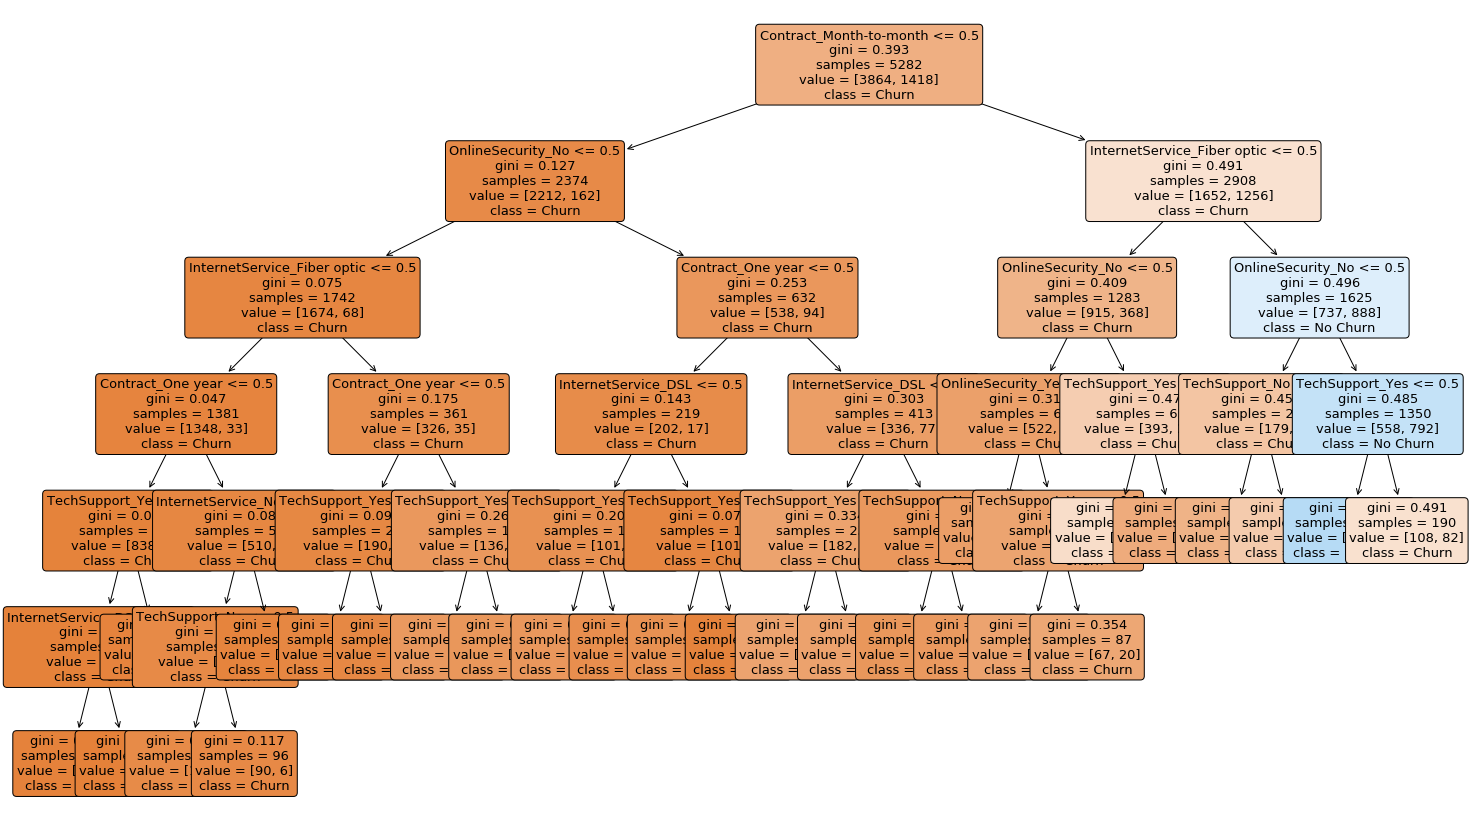

In [22]:
plt.figure(figsize=(25,15))
a = plot_tree(our_tree, 
              feature_names=['Contract_Month-to-month', 'Contract_One year', 'Contract_Two year',
       'OnlineSecurity_No', 'OnlineSecurity_No internet service',
       'OnlineSecurity_Yes', 'TechSupport_No',
       'TechSupport_No internet service', 'TechSupport_Yes',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No'], 
              class_names=['Churn','No Churn'], 
              filled=True, 
              rounded=True, 
              fontsize=13)